In [1]:
# standard library imports
import git, os, sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")
os.chdir(f'{git_root}/src')
sys.path.append(os.path.abspath(os.path.join(f'{git_root}/src')))
print(f'Changed working directory to {os.getcwd()}')

# local imports
from fight_stat_helpers import *
from data_handler import DataHandler
from fight_predictor import FightPredictor

pd.set_option('display.max_rows', 100)  # or any number you'd like

Changed working directory to C:\Users\Alex\OneDrive\Documents\GitHub\UFC_Prediction_2022\src


In [2]:
dh = DataHandler()

In [3]:
ufc_fights_reported_derived_doubled = dh.get('ufc_fights_reported_derived_doubled')
ufc_fights_predictive_flattened_diffs = dh.make_ufc_fights_predictive_flattened_diffs(ufc_fights_reported_derived_doubled)
ufc_fights_winner = dh.clean_ufc_fights_for_winner_prediction(ufc_fights_predictive_flattened_diffs)
fight_predictor = FightPredictor(ufc_fights_winner, dh) # maybe not the best thing to pass in dh here, but it works for now
print('Training logistic regression model on ufc_fights_winner data')
fight_predictor.train_logistic_regression_model(random_state=44) # 44 is the random state we used to get the best model
theta, b, scaler = fight_predictor.get_regression_coeffs_intercept_and_scaler()

print('Scraping next ufc fight card from fightodds.io')
print("###############################################################################################################")    
dh.update_card_info()
card_date, card_title, fights_list = dh.get_next_fight_card()
prediction_history = dh.get('prediction_history', filetype='json')
fighter_stats = dh.get('fighter_stats')


Training logistic regression model on ufc_fights_winner data
Scaling features
Train set accuracy: 0.6423631693341237
Test set accuracy: 0.6200631911532386 

Scraping next ufc fight card from fightodds.io
###############################################################################################################
Writing upcoming card info to content/data/external/card_info.json


In [4]:
vegas_odds_col_names = list(prediction_history.columns)
vegas_odds_col_values = [['' for _ in range(len(fights_list))] for _ in range(len(vegas_odds_col_names))]
vegas_odds_d = dict(zip(vegas_odds_col_names, vegas_odds_col_values))
vegas_odds = pd.DataFrame(data=vegas_odds_d)

vegas_odds['fighter name'] = [fight[0] for fight in fights_list]
vegas_odds['opponent name'] = [fight[1] for fight in fights_list]
# TODO add weight_class into vegas_odds and prediction history
vegas_odds['date'] = card_date

#filling in predictions
i = 0
fighter=vegas_odds['fighter name'][i]
opponent=vegas_odds['opponent name'][i]


In [5]:
tup = fight_predictor.ufc_prediction_tuple(fighter,opponent,card_date,card_date)
tup_scaled = scaler.transform(tup)
value = np.dot(tup_scaled, theta)
presig_value = value + b

C:\Users\Alex\OneDrive\Documents\GitHub\UFC_Prediction_2022\src\data_handler\data_handler.py:669: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ufc_fights_reported_doubled.iloc[-len(new_rows_derived):] = ufc_fights_reported_doubled.iloc[-len(new_rows_derived):].replace(np.nan, 0.0)


Processing fighter 1/2: Tatsuro Taira
Processing fighter 2/2: HyunSung Park


In [6]:
len(theta)

44

In [7]:
df = tup.T
df.columns = ['value']
df['value_scaled'] = tup_scaled.T
df['theta'] = theta
df['contribution'] = df['value_scaled'] * df['theta']
df['abs_contribution'] = df['contribution'].abs()
# sort by contribution
df = df.sort_values(by='abs_contribution', ascending=False)

In [8]:
df

,value,value_scaled,theta,contribution,abs_contribution
l5y_wins_wins_diff,9.000000,2.550683,-0.234792,-0.598881,0.598881
l1y_inf_clinch_strikes_accuracy_diff,-1.000000,-1.919629,0.162058,-0.311091,0.311091
l5y_wins_diff,3.000000,1.117185,0.250509,0.279865,0.279865
age_diff,-4.229979,-0.784536,-0.280776,0.220279,0.220279
all_abs_head_strikes_accuracy_diff,0.254516,1.248059,-0.157770,-0.196907,0.196907
reach_diff,4.000000,1.220818,0.130824,0.159712,0.159712
l5y_inf_takedowns_attempts_per_min_diff,0.208620,0.618147,0.163233,0.100902,0.100902
l3y_inf_head_strikes_accuracy_diff,0.199937,0.937785,0.100906,0.094628,0.094628
all_inf_distance_strikes_accuracy_diff,0.081136,0.394156,0.216118,0.085184,0.085184
l1y_inf_body_strikes_attempts_per_min_diff,-2.265753,-1.907674,-0.043060,0.082144,0.082144


In [9]:
odds_calc = fight_predictor.odds(fighter,opponent,theta,b,scaler)
print('predicting: '+fighter,'versus '+opponent,'.... '+str(odds_calc))
vegas_odds.loc[i, 'predicted fighter odds']=odds_calc[0]
vegas_odds.loc[i, 'predicted opponent odds']=odds_calc[1]

C:\Users\Alex\OneDrive\Documents\GitHub\UFC_Prediction_2022\src\data_handler\data_handler.py:669: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ufc_fights_reported_doubled.iloc[-len(new_rows_derived):] = ufc_fights_reported_doubled.iloc[-len(new_rows_derived):].replace(np.nan, 0.0)


Processing fighter 1/2: Tatsuro Taira
Processing fighter 2/2: HyunSung Park
predicting: Tatsuro Taira versus HyunSung Park .... ['-137', '+137']


# Correlation

We see a lot of negative theta coefficients that I would expect to be positive... Lets try dropping features to reduce multicollinearity. 

We arrived at these features by looking at VIF scores and dropping features with high VIFs, starting with the highest. 

In [10]:
ufc_fights_winner = fight_predictor.ufc_fights_winner.copy()
        
feature_set = [
# 'l5y_overall_fighter_score_diff', # VIF = 10 (no change)
# physical
'age_diff',
'reach_diff',
'height_diff', # added by instinct and it raised test model score
'l5y_wins_diff',
'l1y_wins_sub_diff',
'l1y_wins_ko_diff',
'l3y_wins_ko_diff',
'all_wins_ko_diff',
'l5y_wins_wins_diff',
# 'all_wins_wins_diff',
'l3y_losses_dec_diff',
'all_losses_losses_diff',
'l1y_losses_losses_diff',
# punch stats
'l1y_inf_clinch_strikes_accuracy_diff',
'all_inf_distance_strikes_accuracy_diff', # VIF = 4 (removal decreased test model score)
'all_inf_total_strikes_attempts_per_min_diff',
'l1y_inf_clinch_strikes_landed_per_min_diff',
'all_inf_clinch_strikes_accuracy_diff',
'l5y_inf_knockdowns_per_min_diff',
'l3y_inf_head_strikes_accuracy_diff',
'l5y_inf_body_strikes_accuracy_diff',
'l3y_inf_distance_strikes_landed_per_min_diff',
'l1y_inf_total_strikes_accuracy_diff',
'l1y_inf_body_strikes_attempts_per_min_diff',
'all_abs_head_strikes_accuracy_diff',
'l3y_abs_body_strikes_accuracy_diff',
'l3y_abs_total_strikes_attempts_per_min_diff',
'l1y_abs_clinch_strikes_attempts_per_min_diff',
'all_abs_clinch_strikes_accuracy_diff',
'l3y_abs_leg_strikes_attempts_per_min_diff',
'l1y_abs_body_strikes_attempts_per_min_diff',
'l5y_abs_body_strikes_landed_per_min_diff',
# grappling stats
'all_inf_sub_attempts_per_min_diff',
'l1y_inf_ground_strikes_attempts_per_min_diff',
'l5y_inf_takedowns_attempts_per_min_diff',
'l3y_inf_takedowns_accuracy_diff',
'l3y_inf_takedowns_landed_per_min_diff', # VIF = 4
'l1y_abs_ground_strikes_landed_per_min_diff',
'all_abs_control_per_min_diff',
'all_abs_takedowns_attempts_per_min_diff',
'l3y_abs_takedowns_landed_per_min_diff',
# higher order stats
'l5y_fight_math_diff',
'all_offensive_grappling_score_diff',
'all_defensive_grappling_loss_diff',
'l3y_defensive_grappling_loss_diff',
# 'all_abs_leg_strikes_attempts_per_min_diff', # VIF = 8 (removal increased test model score)
# 'l3y_inf_sub_attempts_per_min_diff', # VIF = 16
# 'l1y_inf_body_strikes_landed_per_min_diff', # VIF = 12 (removal increased test model score)
# 'l1y_abs_total_strikes_attempts_per_min_diff', # VIF = 4
# 'l5y_defensive_grappling_loss_diff', # VIF = 9 (removal decreased test model score)
# 'l3y_overall_fighter_score_diff', # VIF = 24 (removal decreased test model score)
# 'all_inf_head_strikes_accuracy_diff', # VIF = 15 (removal increased test model score)
# 'l3y_inf_sig_strikes_attempts_per_min_diff', # VIF = 16 (removal increased test model score)
# 'l3y_inf_body_strikes_accuracy_diff', # VIF = 19 (removal decreased test model score)
# 'l3y_abs_control_per_min_diff', # VIF = 8 (removal increased test model score)
# 'all_abs_sig_strikes_accuracy_diff', # VIF = 16 (removal decreased test model score)
# 'l1y_abs_clinch_strikes_landed_per_min_diff', # VIF = 19  (removal decreased test model score)
# 'l3y_abs_body_strikes_attempts_per_min_diff', # VIF = 8 (removal decreased test model score)
# 'l3y_abs_body_strikes_landed_per_min_diff', # VIF = 31 (removal increased test model score)
# 'l1y_inf_distance_strikes_accuracy_diff', # VIF = 6 (no change)
# 'l3y_offensive_grappling_score_diff' # VIF = inf (removal increased test model score)
]

In [11]:

ufc_fights_df = ufc_fights_winner[feature_set]
results = ufc_fights_winner['result']
theta, b, scaler = fight_predictor.find_regression_coeffs(ufc_fights_df, results, random_state=99)


Scaling features
Train set accuracy: 0.6358427188302707
Test set accuracy: 0.6429699842022117 



In [12]:

ufc_fights_df = ufc_fights_winner[feature_set]
results = ufc_fights_winner['result']
theta, b, scaler = fight_predictor.find_regression_coeffs(ufc_fights_df, results, random_state=99, scaled=False, C=100)

Train set accuracy: 0.635645129421063
Test set accuracy: 0.641390205371248 



In [13]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [14]:
# Add a constant (intercept term) to the model
X = add_constant(ufc_fights_df)

# Create a DataFrame to hold VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


In [15]:
# sort vif data by VIF value descending
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data

,feature,VIF
14,all_inf_distance_strikes_accuracy_diff,4.385283
21,l3y_inf_distance_strikes_landed_per_min_diff,4.108715
19,l3y_inf_head_strikes_accuracy_diff,3.816113
36,l3y_inf_takedowns_landed_per_min_diff,3.752099
15,all_inf_total_strikes_attempts_per_min_diff,3.485371
43,all_defensive_grappling_loss_diff,3.404694
22,l1y_inf_total_strikes_accuracy_diff,3.070491
17,all_inf_clinch_strikes_accuracy_diff,3.037462
20,l5y_inf_body_strikes_accuracy_diff,3.000308
26,l3y_abs_total_strikes_attempts_per_min_diff,2.993911


In [16]:
ufc_fights_df = ufc_fights_winner[feature_set]
results = ufc_fights_winner['result']
theta, b, scaler = fight_predictor.find_regression_coeffs(ufc_fights_df, results, random_state=99, scaled=False, C=100)

Train set accuracy: 0.635645129421063
Test set accuracy: 0.641390205371248 



In [17]:
tup = fight_predictor.ufc_prediction_tuple(fighter,opponent,card_date,card_date)
if scaler:
    tup_scaled = scaler.transform(tup)
else:
    tup_scaled = tup
value = np.dot(tup_scaled, theta)
presig_value = value + b

df = tup.T
df.columns = ['value']
df['value_scaled'] = tup_scaled.T
df['theta'] = theta
# df['abs_theta'] = df['theta'].abs()
df['contribution'] = df['value_scaled'] * df['theta']
df['abs_contribution'] = df['contribution'].abs()
# sort by contribution
df = df.sort_values(by='abs_contribution', ascending=False)
# df = df.sort_values(by='abs_theta', ascending=False) # really only makes sense when scaled with StandardScaler
df

Processing fighter 1/2: Tatsuro Taira


C:\Users\Alex\OneDrive\Documents\GitHub\UFC_Prediction_2022\src\data_handler\data_handler.py:669: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ufc_fights_reported_doubled.iloc[-len(new_rows_derived):] = ufc_fights_reported_doubled.iloc[-len(new_rows_derived):].replace(np.nan, 0.0)


Processing fighter 2/2: HyunSung Park


,value,value_scaled,theta,contribution,abs_contribution
l5y_wins_wins_diff,9.000000,9.000000,-0.061569,-0.554119,0.554119
l5y_wins_diff,3.000000,3.000000,0.091258,0.273775,0.273775
l1y_inf_clinch_strikes_accuracy_diff,-1.000000,-1.000000,0.258968,-0.258968,0.258968
age_diff,-4.229979,-4.229979,-0.058655,0.248110,0.248110
all_abs_head_strikes_accuracy_diff,0.254516,0.254516,-0.752644,-0.191560,0.191560
reach_diff,4.000000,4.000000,0.034415,0.137660,0.137660
l1y_inf_clinch_strikes_landed_per_min_diff,-1.232877,-1.232877,-0.102158,0.125948,0.125948
l5y_inf_takedowns_attempts_per_min_diff,0.208620,0.208620,0.559514,0.116726,0.116726
all_inf_distance_strikes_accuracy_diff,0.081136,0.081136,0.990210,0.080341,0.080341
l3y_abs_total_strikes_attempts_per_min_diff,-2.846702,-2.846702,-0.027098,0.077139,0.077139


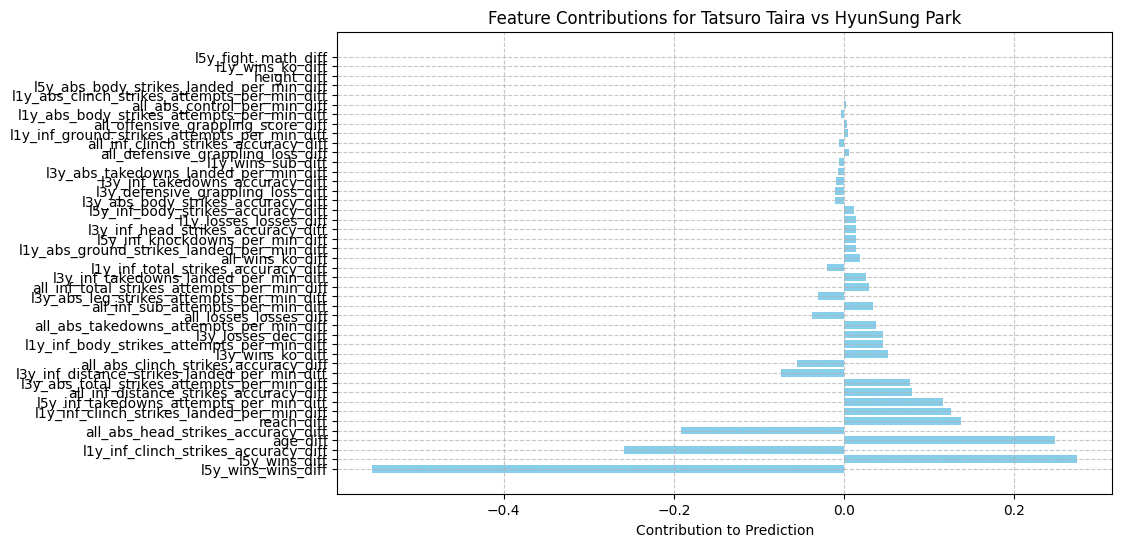

In [18]:
# bar chart of contributions
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(df.index, df['contribution'], color='skyblue')
plt.xlabel('Contribution to Prediction')
plt.title(f'Feature Contributions for {fighter} vs {opponent}')
# make grid lines one per contribution horizontally one one per .1 vertically
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
# --- IGNORE ---

In [19]:
import matplotlib.pyplot as plt
def visualize_prediction(fighter, opponent):
    # opponent goes on left since positive probability means fighter wins
    tup = fight_predictor.ufc_prediction_tuple(fighter,opponent,card_date,card_date)
    if scaler:
        tup_scaled = scaler.transform(tup)
    else:
        tup_scaled = tup
    value = np.dot(tup_scaled, theta)
    presig_value = value + b
    p = 1 / (1 + np.exp(-presig_value))[0]
    print(p)
    if p < 0.5:
        fighterOdds = round(100 / p - 100)
        opponentOdds = round(1 / (1 / (1 - p) - 1) * 100)
        odds = ['-' + str(opponentOdds), '+' + str(fighterOdds)]
    else:
        fighterOdds = round(1 / (1 / p - 1) * 100)
        opponentOdds = round(100 / (1 - p) - 100)
        odds = ['+' + str(opponentOdds), '-' + str(fighterOdds)]

    df = tup.T
    df.columns = ['value']
    df['value_scaled'] = tup_scaled.T
    df['theta'] = theta
    # df['abs_theta'] = df['theta'].abs()
    df['contribution'] = df['value_scaled'] * df['theta']
    df['abs_contribution'] = df['contribution'].abs()
    # sort by contribution
    df = df.sort_values(by='abs_contribution', ascending=False)
    # df = df.sort_values(by='abs_theta', ascending=False) # really only makes sense when scaled with StandardScaler
    # bar chart of contributions
    plt.figure(figsize=(10,6))
    # color bars red if theta is negative, green if positive
    colors = ['green' if x > 0 else 'red' for x in df['theta']]
    plt.barh(df.index, df['contribution'], color=colors)
    plt.xlabel('Contribution to Prediction')
    plt.title(f'{opponent}(p={1-p:.2f}) --vs-- {fighter}(p={p:.2f}) ({odds[0]} / {odds[1]})')
    # make grid lines one per contribution horizontally one one per .1 vertically
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.minorticks_on()

    plt.show()
    # --- IGNOR
    return df

C:\Users\Alex\OneDrive\Documents\GitHub\UFC_Prediction_2022\src\data_handler\data_handler.py:669: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ufc_fights_reported_doubled.iloc[-len(new_rows_derived):] = ufc_fights_reported_doubled.iloc[-len(new_rows_derived):].replace(np.nan, 0.0)


Processing fighter 1/2: Tatsuro Taira
Processing fighter 2/2: HyunSung Park
0.5318588890964034


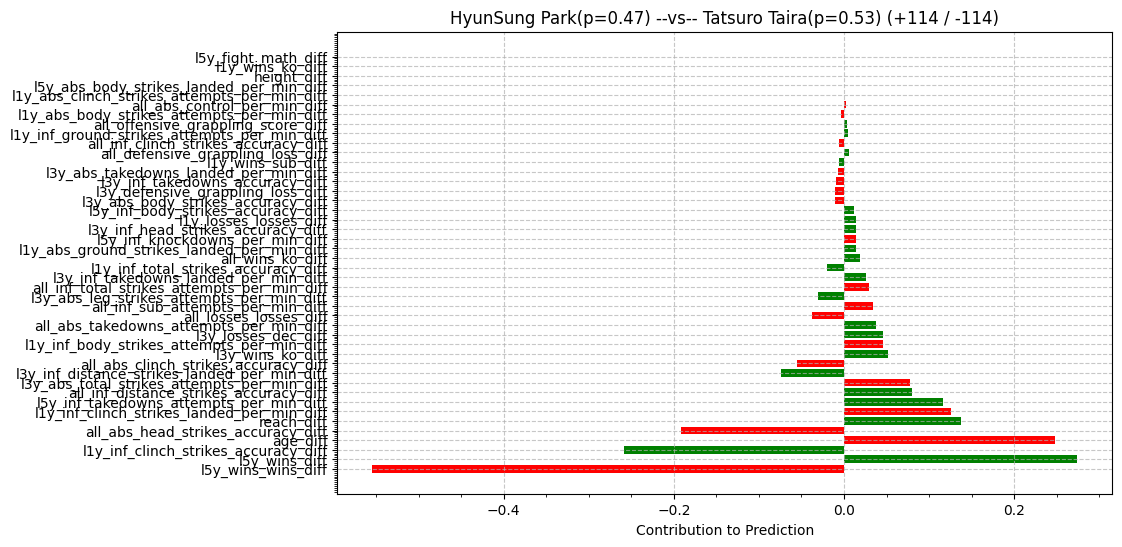

In [20]:
i = 0
fighter=vegas_odds['fighter name'][i]
opponent=vegas_odds['opponent name'][i]
df = visualize_prediction(fighter, opponent)

C:\Users\Alex\OneDrive\Documents\GitHub\UFC_Prediction_2022\src\data_handler\data_handler.py:669: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ufc_fights_reported_doubled.iloc[-len(new_rows_derived):] = ufc_fights_reported_doubled.iloc[-len(new_rows_derived):].replace(np.nan, 0.0)


Processing fighter 1/2: Mateusz Rebecki
Processing fighter 2/2: Chris Duncan
0.40854242853937545


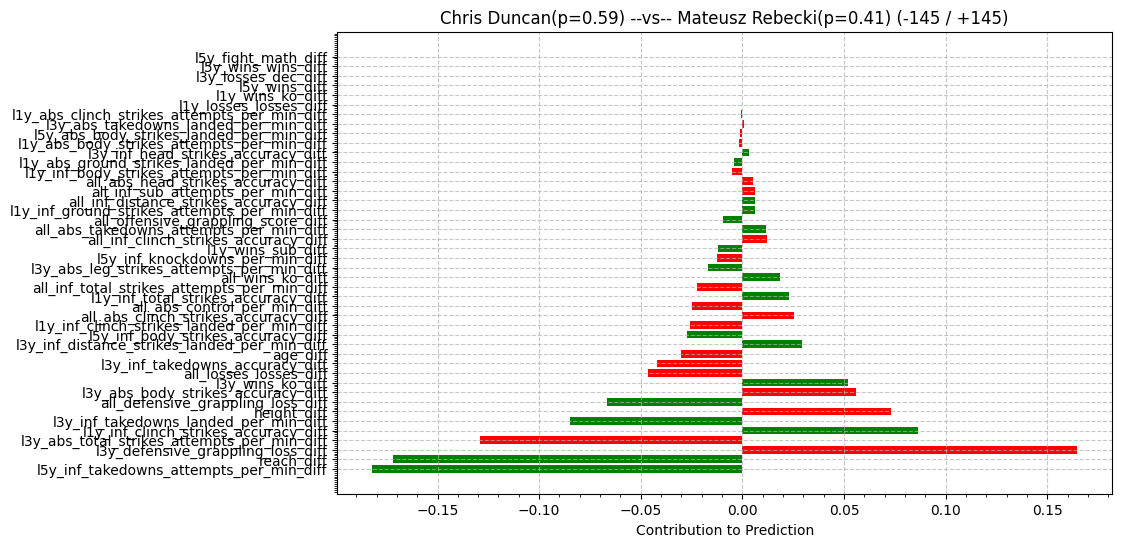

In [21]:
# reach theta is positive and duncan has a longer reach but rebecki gets positive contribution from reach diff ?? ITS WRONG
i = 1
fighter=vegas_odds['fighter name'][i]
opponent=vegas_odds['opponent name'][i]
df = visualize_prediction(fighter, opponent)

In [22]:
df

,value,value_scaled,theta,contribution,abs_contribution
l5y_inf_takedowns_attempts_per_min_diff,-0.325316,-0.325316,0.559514,-0.182019,0.182019
reach_diff,-5.000000,-5.000000,0.034415,-0.172075,0.172075
l3y_defensive_grappling_loss_diff,-2.797578,-2.797578,-0.058847,0.164630,0.164630
l3y_abs_total_strikes_attempts_per_min_diff,4.760507,4.760507,-0.027098,-0.128998,0.128998
l1y_inf_clinch_strikes_accuracy_diff,0.333333,0.333333,0.258968,0.086323,0.086323
l3y_inf_takedowns_landed_per_min_diff,-2.952639,-2.952639,0.028697,-0.084731,0.084731
height_diff,-3.000000,-3.000000,-0.024401,0.073203,0.073203
all_defensive_grappling_loss_diff,-2.797578,-2.797578,0.023831,-0.066670,0.066670
l3y_abs_body_strikes_accuracy_diff,-0.170000,-0.170000,-0.329642,0.056039,0.056039
l3y_wins_ko_diff,1.000000,1.000000,0.052085,0.052085,0.052085


C:\Users\Alex\OneDrive\Documents\GitHub\UFC_Prediction_2022\src\data_handler\data_handler.py:669: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ufc_fights_reported_doubled.iloc[-len(new_rows_derived):] = ufc_fights_reported_doubled.iloc[-len(new_rows_derived):].replace(np.nan, 0.0)


Processing fighter 1/2: Elves Brener
Processing fighter 2/2: Esteban Ribovics
0.6458762754161684


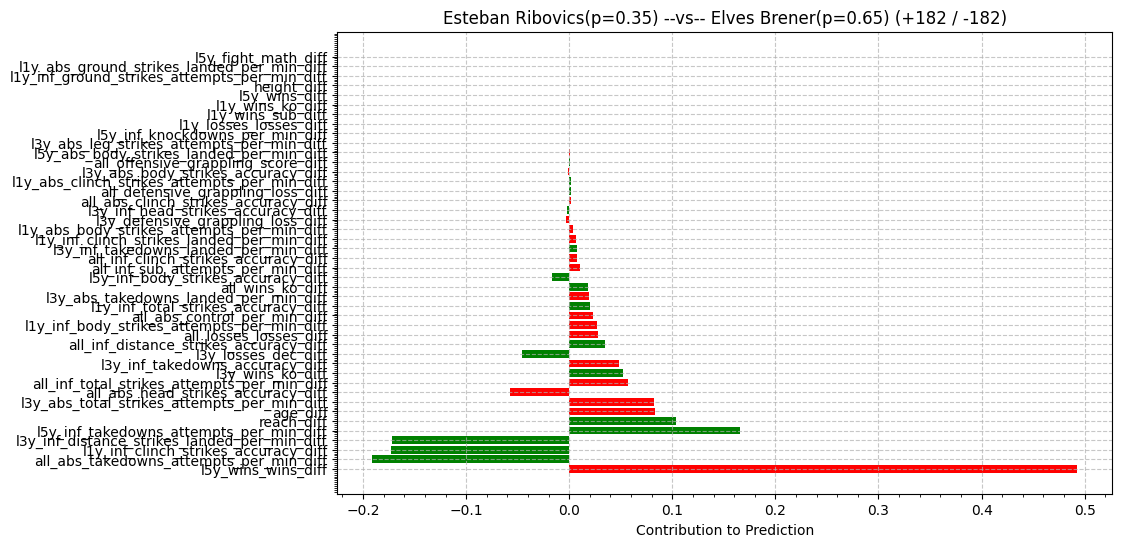

In [23]:
i = 2
fighter=vegas_odds['fighter name'][i]
opponent=vegas_odds['opponent name'][i]
df = visualize_prediction(fighter, opponent)